In [1]:
import os
import cv2
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
import random
import numpy as np
from matplotlib import pyplot as plt
import torch
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.io import read_image
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models

In [2]:
# Define the directory containing the augmented images
data_dir = "C:\\Users\\wisea\\Transfer\\Deep_Learning_Files\\ProjectFilles\\Data"

# Define the transformations to be applied to the images
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [15]:
# Function to load and augment images from a directory
def augment_images(directory, num_augments):
    augmented_images = []
    for filename in os.listdir(directory):
        # Load the original image
        image_path = os.path.join(directory, filename)
        original_image = Image.open(image_path)
        
        # Apply transformations to the original image
        for _ in range(num_augments):
            # Generate a random set of transformations for each augmentation
            chosen_transforms = [
                transforms.RandomRotation(degrees=30),
                transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
                transforms.RandomGrayscale(p=0.1),
                transforms.RandomHorizontalFlip(p=0.5),
                transforms.RandomVerticalFlip(p=0.5)
            ]
            composed_transform = transforms.Compose(chosen_transforms)
            augmented_image = composed_transform(original_image)
            augmented_images.append(transform(augmented_image))
    return augmented_images

# Define the subfolders containing the images
subfolders = ['Alopecia-Pictures', 'seborrheic-dermatitis-pictures', 'Psoriasis-pictures']

# Create a dictionary to store augmented images for each subfolder
augmented_images_by_subfolder = {}

# Augment images for each subfolder
for subfolder in subfolders:
    subfolder_path = os.path.join(data_dir, subfolder)
    print(subfolder_path)
    num_images = len(os.listdir(subfolder_path))
    
    # Augment each image 20 times with different transformations
    augmented_images = augment_images(subfolder_path, num_augments=20)
    augmented_images_by_subfolder[subfolder] = augmented_images

# Convert the augmented images to torch tensors
augmented_images_tensors_by_subfolder = {}
for subfolder, images in augmented_images_by_subfolder.items():
    augmented_images_tensors_by_subfolder[subfolder] = torch.stack(images)

# Display the size of tensors for each subfolder
for subfolder, tensors in augmented_images_tensors_by_subfolder.items():
    print(f"Subfolder: {subfolder}, Tensor size: {tensors.size()}")

C:\Users\wisea\Transfer\Deep_Learning_Files\ProjectFilles\Data\Alopecia-Pictures
C:\Users\wisea\Transfer\Deep_Learning_Files\ProjectFilles\Data\seborrheic-dermatitis-pictures
C:\Users\wisea\Transfer\Deep_Learning_Files\ProjectFilles\Data\Psoriasis-pictures
Subfolder: Alopecia-Pictures, Tensor size: torch.Size([1640, 3, 224, 224])
Subfolder: seborrheic-dermatitis-pictures, Tensor size: torch.Size([800, 3, 224, 224])
Subfolder: Psoriasis-pictures, Tensor size: torch.Size([2020, 3, 224, 224])



Showing images from subfolder: Alopecia-Pictures


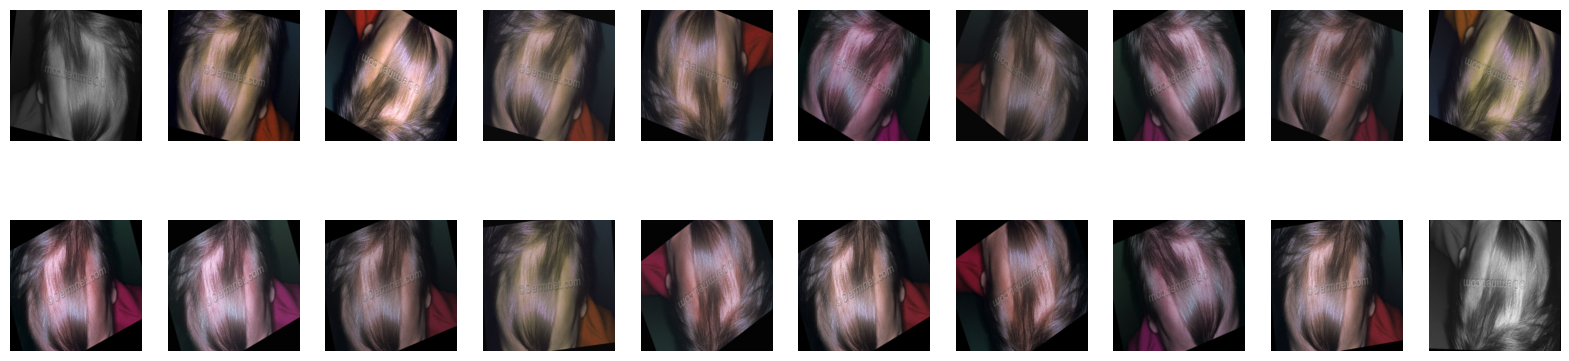


Showing images from subfolder: seborrheic-dermatitis-pictures


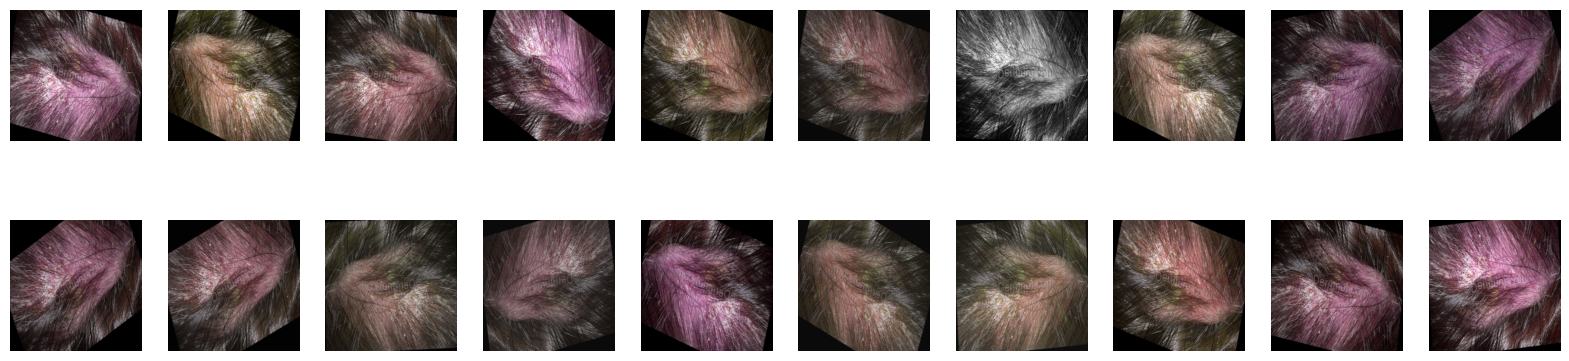


Showing images from subfolder: Psoriasis-pictures


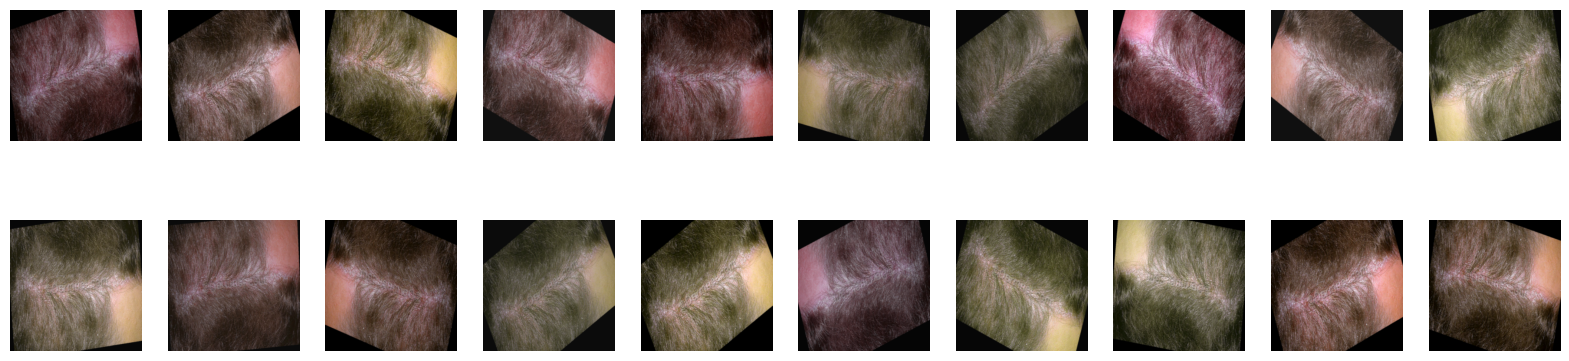

In [4]:
# Display 20 pictures from each subfolder
for subfolder, images in augmented_images_by_subfolder.items():
    print(f"\nShowing images from subfolder: {subfolder}")
    plt.figure(figsize=(20, 5))
    for i in range(20):  # Displaying 20 images from each subfolder
        plt.subplot(2, 10, i + 1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.axis('off')
    plt.show()

In [5]:
# Combine all augmented images and create labels
all_images = torch.cat([torch.stack(images) for images in augmented_images_by_subfolder.values()], dim=0)
num_classes = len(subfolders)
all_labels = torch.tensor(sum([[i] * len(images) for i, images in enumerate(augmented_images_by_subfolder.values())], []))

# Split data into training and validation sets
dataset = list(zip(all_images, all_labels))
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Define DataLoader for training and validation sets
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Check the sizes of training and validation sets
print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 3568
Validation set size: 892


In [16]:
model = models.resnet50(pretrained=True)
print(model)

c:\Users\wisea\anaconda3\envs\Tensorflow\lib\site-packages\torchvision\models\_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and may be removed in the future, "
c:\Users\wisea\anaconda3\envs\Tensorflow\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [17]:
# Freeze parameters of the pre-trained model
for param in model.parameters():
    param.requires_grad = False

In [18]:
# Modify the fully connected layer to match the number of classes in your dataset
num_classes = 3
model.fc = nn.Linear(model.fc.in_features, num_classes)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(device)

cpu


In [20]:
num_epochs = 25
unfreeze_epoch = 10  # Unfreeze parameters after this epoch
for epoch in range(num_epochs):
    # Unfreeze parameters gradually starting from unfreeze_epoch
    if epoch >= unfreeze_epoch:
        for param in model.parameters():
            param.requires_grad = True

    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()
    
    # Validation
    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss = criterion(outputs, labels)
            val_running_loss += val_loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()
    
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc_train = correct_train / total_train
    val_epoch_loss = val_running_loss / len(val_dataset)
    epoch_acc_val = correct_val / total_val
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss: {epoch_loss:.4f}, Train Accuracy: {100*epoch_acc_train:.2f}%, Validation Loss: {val_epoch_loss:.4f}, Validation Accuracy: {100*epoch_acc_val:.2f}%")

Epoch 1/25: Train Loss: 0.8866, Train Accuracy: 64.66%, Validation Loss: 0.7876, Validation Accuracy: 71.30%
Epoch 2/25: Train Loss: 0.7054, Train Accuracy: 73.09%, Validation Loss: 0.6729, Validation Accuracy: 74.55%
Epoch 3/25: Train Loss: 0.6232, Train Accuracy: 76.60%, Validation Loss: 0.6196, Validation Accuracy: 75.45%
Epoch 4/25: Train Loss: 0.5722, Train Accuracy: 78.67%, Validation Loss: 0.5655, Validation Accuracy: 79.71%
Epoch 5/25: Train Loss: 0.5352, Train Accuracy: 80.80%, Validation Loss: 0.5361, Validation Accuracy: 78.59%
Epoch 6/25: Train Loss: 0.5063, Train Accuracy: 81.98%, Validation Loss: 0.5051, Validation Accuracy: 81.95%
Epoch 7/25: Train Loss: 0.4826, Train Accuracy: 82.79%, Validation Loss: 0.4976, Validation Accuracy: 80.04%
Epoch 8/25: Train Loss: 0.4666, Train Accuracy: 83.32%, Validation Loss: 0.4687, Validation Accuracy: 82.51%
Epoch 9/25: Train Loss: 0.4397, Train Accuracy: 85.23%, Validation Loss: 0.4621, Validation Accuracy: 82.06%
Epoch 10/25: Train 

In [21]:
# Load the image
image_path = "C:\\Users\\wisea\\Downloads\\22828-scalp-psoriasis-1127052066.jpg"
image = Image.open(image_path)

# Define transformations to preprocess the image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to match the input size of your model
    transforms.ToTensor(),           # Convert to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])

# Apply transformations
input_image = transform(image).unsqueeze(0)  # Add batch dimension

# Perform inference
model.eval()  # Set model to evaluation mode
with torch.no_grad():
    outputs = model(input_image)

# Post-process the predictions
probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
predicted_class = torch.argmax(probabilities).item()

# Print the predicted class name
class_names = ['Alopecia', 'Psoriasis', 'sebhorric dermatitis']  # List of class names
predicted_class_name = class_names[predicted_class]
print("Predicted class:", predicted_class_name)


Predicted class: Alopecia
